# Yield Rate Gender Gap, Part 2: Cleaning the Data
*This is Part 2 of an investigation into the yield rate disparity in college admissions between women and men. This is a personal project I started to help me tie together using python for web scraping, data cleaning, data visualization, hypothesis testing, statistical modeling, machine learning, and more. I appreciate feedback!*

---

Let's import and check the shape of the the raw data we scraped from CollegeData.com back in Part 1:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

college = pd.read_csv('data/collegedata_scraped_backup.csv',
                      index_col=0, na_values='Not reported')
college.index.name = 'schoolId'
college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2030 entries, 6 to 3379
Data columns (total 62 columns):
schoolname                               2030 non-null object
location                                 2030 non-null object
Overall Admission Rate                   1628 non-null object
Women                                    1508 non-null object
Men                                      1512 non-null object
Students Enrolled                        1410 non-null object
Women*                                   1576 non-null object
Men*                                     1545 non-null object
Early Decision Admission Rate            199 non-null object
Early Action Admission Rate              241 non-null object
Students Offered Wait List               338 non-null object
Students Accepting Wait List Position    298 non-null object
Students Admitted From Wait List         327 non-null object
Average GPA                              1383 non-null object
3.75 and Above                

We scraped 53 columns of data from 1813 different schools. For reference, [this is what Penn State's data looks like in its original form on CollegeData.com](https://www.collegedata.com/cs/data/college/college_pg02_tmpl.jhtml?schoolId=59).

---
## Identifying null values

We scraped the school name, the location, and everything in the "Profile of Fall Admission" table. The column labels of our raw scraped data are:

If you look up enough schools on CollegeData.com, you'll notice not every school has information available for each column here. Very sparsely populated columns - that is columns filled with **null values** - may not be very useful in helping us analyze the yield rate disparity.

Pandas saves null values with the `np.NaN` value. CollegeData.com probably uses something more friendly to indicate a null value to a human reader. Assuming there is a bunch of null values in the dataset, can get an idea of the potential null value CollegeData.com uses by looking at the most common values that appear in each column of the DataFrame with the `.mode()` method.

---
## Dropping sparse columns
Now that we've got null data properly marked, we can check what columns are filled with null data and potentially drop them. I'm going to consider dropping columns that are more than 75% null.

In [2]:
sparse_cols = college.columns[college.isnull().sum() > 0.75*len(college)]
list(sparse_cols)

['Early Decision Admission Rate',
 'Early Action Admission Rate',
 'Students Offered Wait List',
 'Students Accepting Wait List Position',
 'Students Admitted From Wait List',
 'National Merit Scholar',
 'Valedictorian',
 'Class President',
 'Student Government Officer']

In a future analysis of only the most selective schools, it could be useful to keep track of the few schools that offer early admission. Regarding the remaining columns, there is just too little data inconsistently reported for them to serve as useful predictors for any models we build to predict the yield rate disparity across all schools.

After dropping these columns, let's see what remains:

In [3]:
college = college.drop(columns=sparse_cols)

---
## Dropping related columns

Referring back to Penn State's CollegeData.com page, each column in the pattern of "Score of ### - ###" show the percentage of applicants who scored in that range on one of the standardized tests. While this is potentially interesting for a future analysis, we already get the mean and middle 50% for each test in the `SAT Math`, `SAT Critical Reading`, `SAT Writing`, and `ACT Composite` columns. Similarly, each "#.## - #.##" column contains the percentage of students who earned GPA in that ranges, but we already get the mean GPA of applicants in the `Average GPA` column.

Since these score range columns likely correlate with the mean score columns, we can drop the score range columns without losing the ability to use SAT/ACT/GPA scores as a potential predictor for the yield rate disparity.

As it turns out, to drop these columns, we can simply remove any column from the list that has a label containing a number.

In [4]:
drop_cols = college.columns[college.columns.str.contains(r'[\d]')]
college = college.drop(columns = drop_cols)

---
## Removing commas
Large numbers in this dataset contain commas to separate thousands. We will remove all commas from the data in every column to make it easier to later extract numbers.

In [5]:
for col in college.select_dtypes('object').columns:
    college[col] = college[col].str.replace(',','')

---
## 'Students Enrolled','Women\*', and 'Men\*' columns

Our surviving columns are:

In [6]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2030 entries, 6 to 3379
Data columns (total 23 columns):
schoolname                         2030 non-null object
location                           2030 non-null object
Overall Admission Rate             1628 non-null object
Women                              1508 non-null object
Men                                1512 non-null object
Students Enrolled                  1410 non-null object
Women*                             1576 non-null object
Men*                               1545 non-null object
Average GPA                        1383 non-null object
SAT Math                           1313 non-null object
SAT Critical Reading               1300 non-null object
SAT Writing                        850 non-null object
ACT Composite                      1403 non-null object
High School Class Rank             1120 non-null object
Coeducational                      2021 non-null object
All Undergraduates                 1921 non-null objec

Though we now only have these 14 columns for each school, there are more than 14 pieces of numeric data saved inside these columns. 

For Penn State, for example, the `'Students Enrolled'`, `'Women*'`, and `'Men*'` columns contain: 

We neeed to split these columns, and nearly all of the other columns as well, into separate columns:

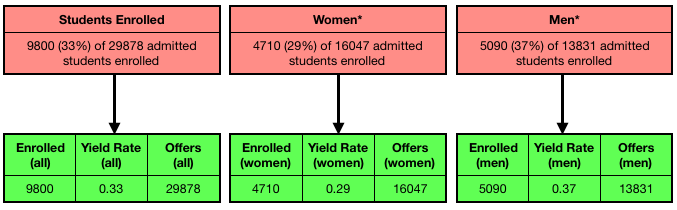

We can use pandas `.str.extract()` method with a **regular expression** argument, which will output a new column of data for each group in the regular expression. We can then chain the `.astype()` method to convert the output columns to our desired data type. We can then convert any percentage columns to decimal numbers by dividing them by 100. 

In [7]:
# Create newdf with multilevel columns and schoolId index
fields = ['Apps','Offer Rate','Offers','Yield Rate','Enrolled','Undergrads']
genders = ['All','Men','Women']
df = pd.DataFrame(index = college.index, \
        columns = pd.MultiIndex.from_product([fields, genders]))

# Regexps used to extract new columns.
regexps = dict(zip(fields, \
        ['\D+(\d+)', '(\d+)%', 'of (\d+)', '(\d+)%', '^(\d+)', '^(\d+)']))

# Map new (Field, Gender) cols to original columns. 
column_map = {
    'Apps': dict(zip(genders, ['Overall Admission Rate','Men','Women'])),
    'Offer Rate': dict(zip(genders, \
            ['Overall Admission Rate','Men','Women'])),
    'Offers': dict(zip(genders, ['Students Enrolled','Men*','Women*'])),
    'Yield Rate': dict(zip(genders, ['Students Enrolled','Men*','Women*'])),
    'Enrolled': dict(zip(genders, ['Students Enrolled','Men*','Women*'])),
    'Undergrads': dict(zip(genders, \
            ['All Undergraduates','Undergrads (men)','Undergrads (women)']))
}

# Populate new columns by extracting from old columns.
for new_col, old_cols in column_map.items():
    re = regexps[new_col]
    for gender in genders:
        df[new_col, gender] = college[old_cols[gender]].str.extract(re)

# Convert to floating point and rates to percents.
df = df.astype('float')
df['Offer Rate'] /= 100
df['Yield Rate'] /= 100

df[['Apps','Offers','Enrolled','Undergrads']].head()

Apps                  Offers                 Enrolled         \
              All     Men   Women     All     Men   Women      All    Men   
schoolId                                                                    
6           439.0   145.0   294.0   185.0    74.0   111.0     98.0   44.0   
7         11863.0  4044.0  7819.0  8339.0  2695.0  5644.0   1822.0  540.0   
8          1583.0   545.0  1038.0  1067.0   362.0   705.0    250.0   93.0   
9           780.0   293.0   487.0   519.0   180.0   339.0    488.0  162.0   
10         8832.0     NaN     NaN  4514.0  1730.0  2784.0    596.0  245.0   

                 Undergrads                  
           Women        All     Men   Women  
schoolId                                     
6           54.0      295.0   148.0   147.0  
7         1282.0     5205.0  1634.0  3571.0  
8          157.0     1078.0   432.0   646.0  
9          326.0     1220.0   406.0   814.0  
10         351.0     2304.0   913.0  1391.0

In [8]:
# Location.
df['Location','City'] = college['location'].str.extract('(.*)\s[A-Z]{2}')
df['Location','State'] = college['location'].str.extract('([A-Z]{2})') \
                                                        .astype('category')
df['Location','Zip'] = college['location'].str.extract('(\d{5})') \
                                                        .astype('int')

# SAT.
re = '^(\d+)'
df['SAT','Math Mean'] = college['SAT Math'].str.extract(re)
df['SAT','Reading Mean'] = college['SAT Critical Reading'].str.extract(re)
df['SAT','Writing Mean'] = college['SAT Writing'].str.extract(re)
df['SAT'] = df['SAT'].astype('float')

# ACT.
df['ACT','Mean'] = college['ACT Composite'].str.extract(re)
df['ACT'] = df['ACT'].astype('float')

# GPA.
re = '([\d\.]{4})'
df['GPA','Mean'] = college['Average GPA'].str.extract(re)
df['GPA'] = df['GPA'].astype('float')

# HS class rank.
col = 'High School Class Rank'
re = 'Top tenth:\s*(\d+)%'
df['HS Rank','Top 10th'] = college[col].str.extract(re).astype('float')
re = 'Bottom half:\s*(\d+)%'
df['HS Rank','Bottom 50th'] = college[col].str.extract(re).astype('float')
df['HS Rank'] /= 100

# Coed status.
cats = {'Yes':'Yes','No women only':'Women Only','No men only':'Men Only'}
df['Category','Coed'] = college['Coeducational'].astype('category') \
                                                .cat.rename_categories(cats)

# Grad students.
df['Grads','All'] = college['All Graduate Students'].astype('float')

# Mean age.
df['Age','Mean'] = college['Average Age'].astype('float')

# Domestic demographics.
col = 'Ethnicity of Students from U.S.'
ethnicities = ['American Indian','Asian','Black','Hispanic',
               'Multi','Native Hawaiian','White','Unknown']
re = '([\d\.]+)% '
for ethnicity in ethnicities:
    df['Demographics', ethnicity] = college[col].str.extract(re + ethnicity)
df['Demographics'] = df['Demographics'].astype('float') / 100

# International students.
df['Intl','Intl'] = college['International Students'].str.extract(re)
df['Intl'] = df['Intl'].astype('float') / 100

# Fix duplicate school names and set as index.
duplicated = college['schoolname'].duplicated(keep = False)
for i, row in college.loc[duplicated].iterrows():
    college.loc[i, 'schoolname'] += ' (' + df.loc[i, ('Location','State')] + ')'
duplicated = college['schoolname'].duplicated(keep = False)
for i, row in college.loc[duplicated].iterrows():
    college.loc[i, 'schoolname'] += ' (' + df.loc[i, ('Location','City')] + ')'

df = df.set_index(college['schoolname'].values).sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2030 entries, Abilene Christian University to Youngstown State University
Data columns (total 40 columns):
(Apps, All)                        1628 non-null float64
(Apps, Men)                        1487 non-null float64
(Apps, Women)                      1483 non-null float64
(Offer Rate, All)                  1628 non-null float64
(Offer Rate, Men)                  1487 non-null float64
(Offer Rate, Women)                1483 non-null float64
(Offers, All)                      1324 non-null float64
(Offers, Men)                      1286 non-null float64
(Offers, Women)                    1328 non-null float64
(Yield Rate, All)                  1324 non-null float64
(Yield Rate, Men)                  1286 non-null float64
(Yield Rate, Women)                1328 non-null float64
(Enrolled, All)                    1410 non-null float64
(Enrolled, Men)                    1545 non-null float64
(Enrolled, Women)                  1576 non-null f

After dropping, splitting, and cleaning, we transformed our original, raw scraped 2030 school dataframe from 62 dirty columns wide to 41 clean columns wide. 

We can check data for Penn State and Colorado State:

In [9]:
df.loc["Penn State University Park"]

Apps          All                          52974
              Men                          25925
              Women                        27049
Offer Rate    All                           0.56
              Men                           0.53
              Women                         0.59
Offers        All                          29878
              Men                          13831
              Women                        16047
Yield Rate    All                           0.33
              Men                           0.37
              Women                         0.29
Enrolled      All                           9800
              Men                           5090
              Women                         4710
Undergrads    All                          41359
              Men                          22145
              Women                        19214
Location      City               University Park
              State                           PA
              Zip   

Everything looks good here. The NaN for the SAT Writing is appropriate since Penn State did not consider the SAT Writing in admissions - CollegeData.com showed values of 'Not reported'.

---

## Exporting the dataframe
We will save the cleaned dataframe to a new .csv file.

In [10]:
df.to_csv('data/collegedata_cleaned_backup.csv', index_label='Name')

In Part 3, we will import a separate dataset of US News and World Report's college rankings and combine it with our cleaned school dataset.